In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import os

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
def load_data(fpath='data/SP1.csv'):
    if os.path.isfile(fpath):
        return pd.read_csv(fpath)
    return None

In [4]:
df = load_data()
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,SP1,16/08/2019,20:00,Ath Bilbao,Barcelona,1,0,H,0,0,...,1.97,0.75,1.93,2.00,1.91,2.01,2.02,2.03,1.91,1.98
1,SP1,17/08/2019,16:00,Celta,Real Madrid,1,3,A,0,1,...,2.63,1.00,1.82,1.97,1.85,2.07,2.00,2.20,1.82,2.06
2,SP1,17/08/2019,18:00,Valencia,Sociedad,1,1,D,0,0,...,1.82,-0.75,1.94,1.99,1.92,2.00,1.96,2.12,1.89,2.00
3,SP1,17/08/2019,19:00,Mallorca,Eibar,2,1,H,1,0,...,1.66,0.00,2.11,1.82,2.09,1.83,2.12,1.88,2.07,1.83
4,SP1,17/08/2019,20:00,Leganes,Osasuna,0,1,A,0,0,...,1.46,-0.50,1.89,2.04,1.90,2.01,1.95,2.06,1.90,1.99


In [5]:
def prepare_data(df: pd.DataFrame):
    df = df.loc[:, ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'}, inplace=True)
    team_categorical = pd.Categorical(df.HomeTeam)
    df['HomeTeamId'] = team_categorical.codes
    df['AwayTeamId'] = pd.Categorical(df.AwayTeam, dtype=team_categorical.dtype).codes
    return df

In [6]:
df = prepare_data(df)
df.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,HomeTeamId,AwayTeamId
0,Ath Bilbao,Barcelona,1,0,1,3
1,Celta,Real Madrid,1,3,5,14
2,Valencia,Sociedad,1,1,17,16
3,Mallorca,Eibar,2,1,12,6
4,Leganes,Osasuna,0,1,10,13


In [7]:
n_teams = len(df.HomeTeam.unique())
print(f'Total teams = {n_teams}')

Total teams = 20


## Model 1

No home advantage. 

attack_group_mean ~ Normal(0, 1)  
attack_group_sd ~ HalfCauchy(1)  
attack_team<sub>i</sub> ~ Normal(attack_group_mean, attack_group_sd)  

defense_group_mean ~ Normal(0, 1)  
defense_group_sd ~ HalfCauchy(1)  
defense_team<sub>i</sub> ~ Normal(defense_group_mean, defense_group_sd)  

log(home_rate<sub>i, j</sub>) = attack_team<sub>i</sub> - defense_team<sub>j</sub>  
home_goals<sub>i, j</sub> ~ Poisson(home_rate<sub>i, j</sub>)<br>
log(away_rate<sub>i, j</sub>) = attack_team<sub>j</sub> - defense_team<sub>i</sub>  
away_goals<sub>i, j</sub> ~ Poisson(away_rate<sub>i, j</sub>)

In [8]:
with pm.Model() as model_1:
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=1)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team = pm.Normal('attack_team', mu=attack_group_mean, sd=attack_group_sd, shape=n_teams)
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=1)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team = pm.Normal('defense_team', mu=defense_group_mean, sd=defense_group_sd, shape=n_teams)
    
    home_rate = pm.math.exp(attack_team[df.HomeTeamId] - defense_team[df.AwayTeamId])
    away_rate = pm.math.exp(attack_team[df.AwayTeamId] - defense_team[df.HomeTeamId])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    trace_1 = pm.sample(1000, tune=1000)

/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Usi

/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matp

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a130462d0>,
      dtype=object)

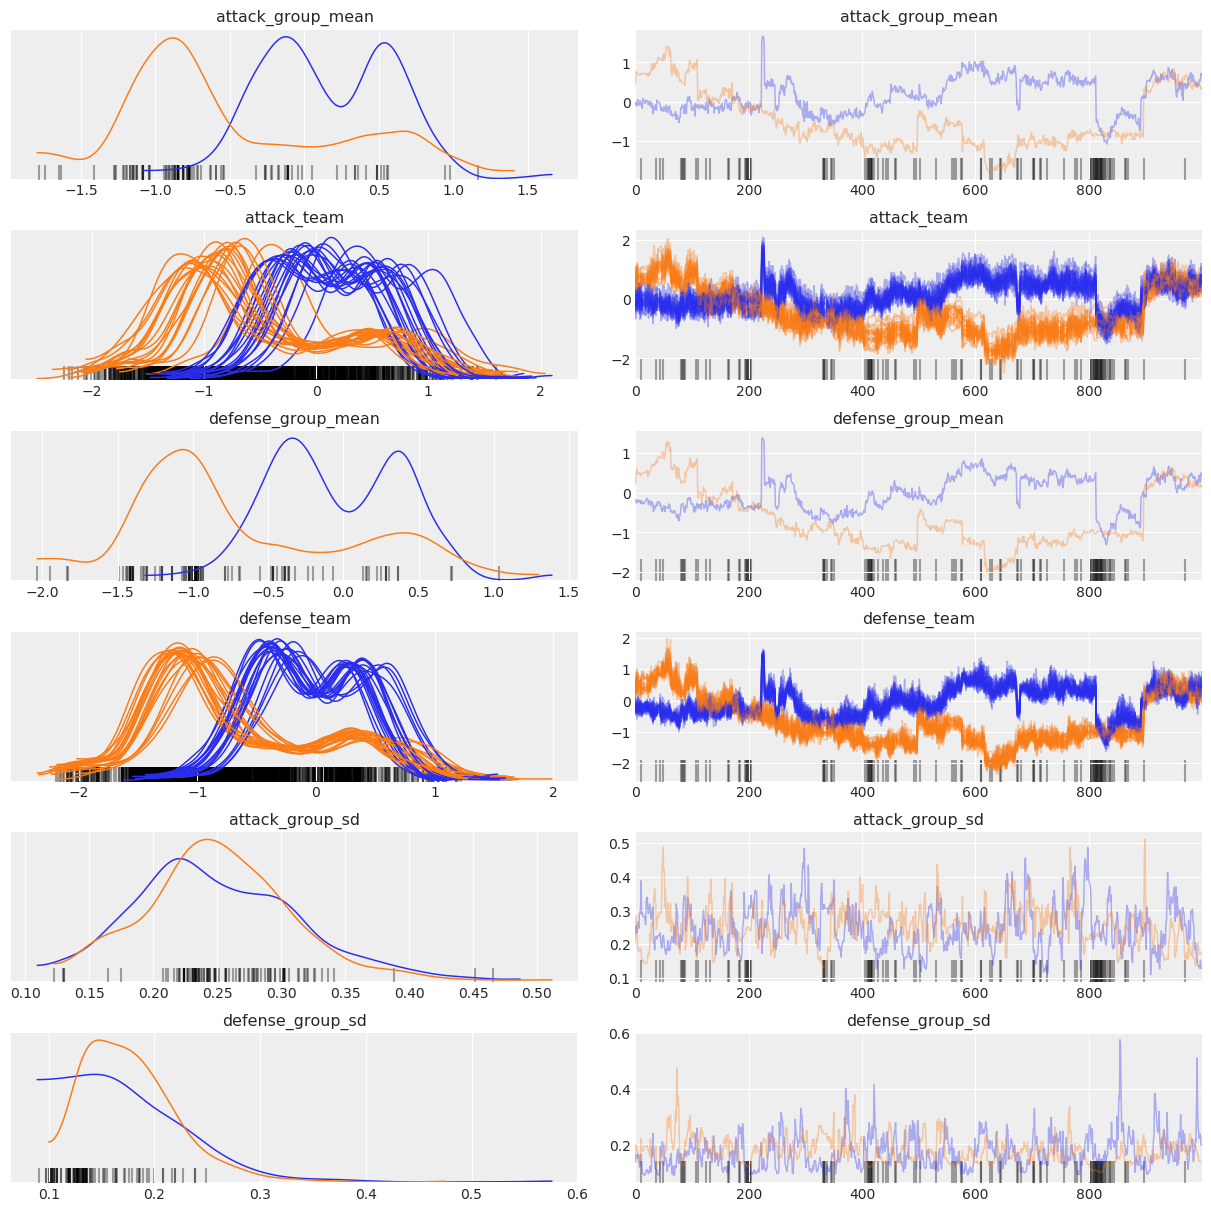

In [9]:
az.plot_trace(trace_1, compact=True)

* Too many divergences in model 1.
* Chains do not converge and mix properly.
* R hat statistic too large

Need to reparametrize the model

## Model 1 non-centered parametrization

In [10]:
with pm.Model() as model_1_nc:
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=1)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team_z = pm.Normal('attack_team_z', mu=0, sd=1, shape=n_teams)
    attack_team = pm.Deterministic('attack_team', attack_group_mean + attack_group_sd * attack_team_z)
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=1)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team_z = pm.Normal('defense_team_z', mu=0, sd=1, shape=n_teams)
    defense_team = pm.Deterministic('defense_team', defense_group_mean + defense_group_sd * defense_team_z)
    
    home_rate = pm.math.exp(attack_team[df.HomeTeamId] - defense_team[df.AwayTeamId])
    away_rate = pm.math.exp(attack_team[df.AwayTeamId] - defense_team[df.HomeTeamId])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    trace_1_nc = pm.sample(1000, tune=1000)

/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defense_team_z, defense_group_sd, defense_group_mean, attack

/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matp

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a117a5750>,
      dtype=object)

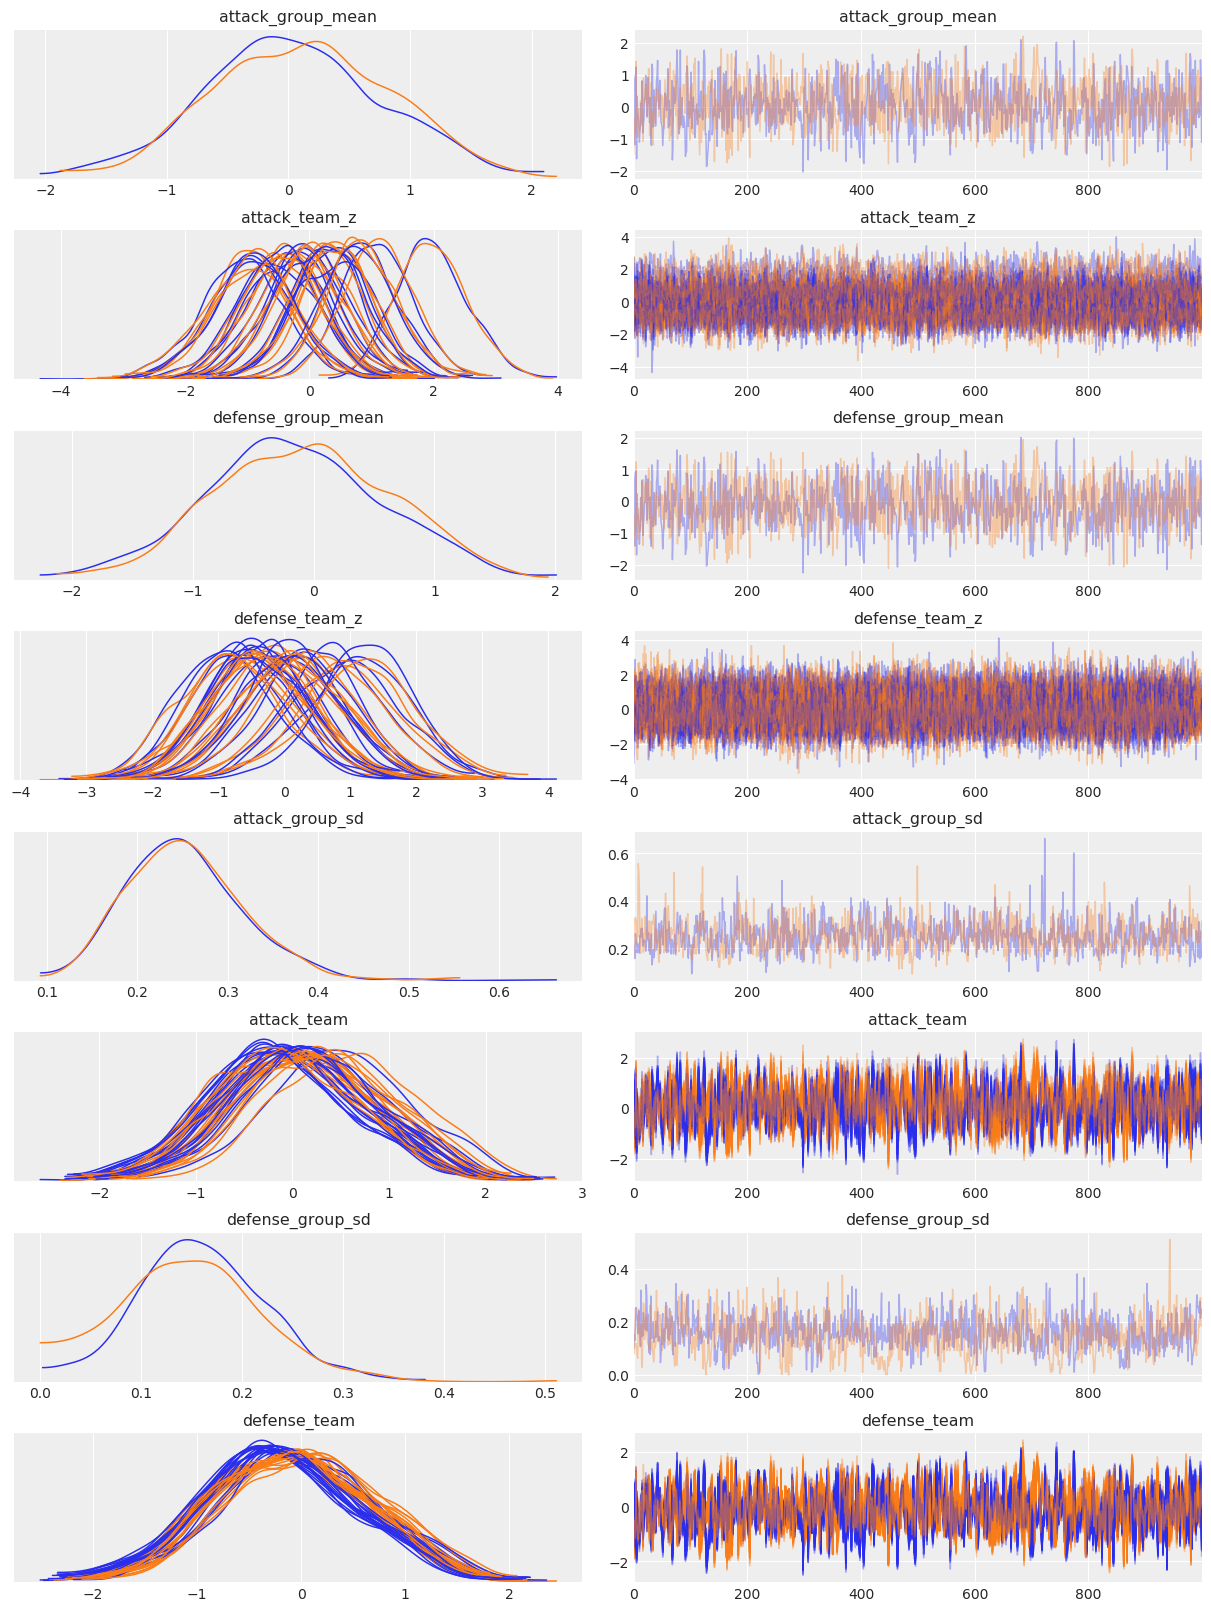

In [11]:
az.plot_trace(trace_1_nc, compact=True)

Text(0, 0.5, 'Density')

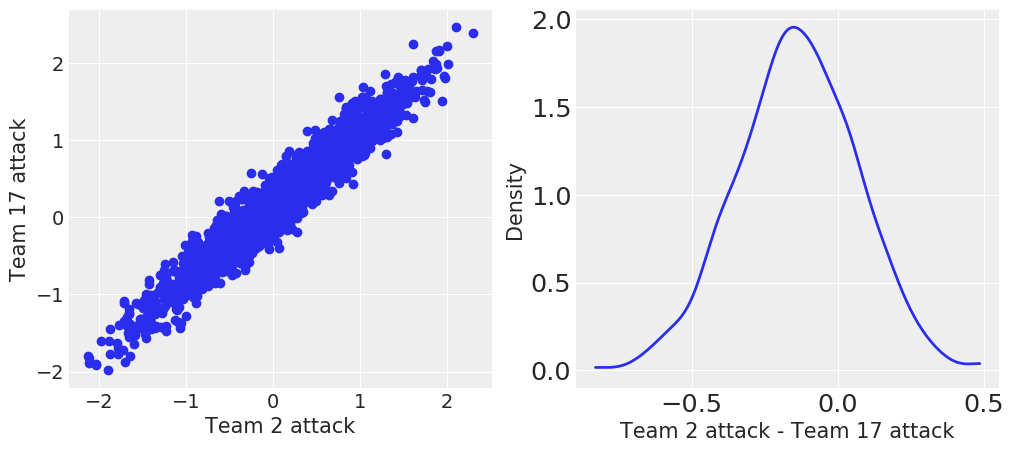

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(trace_1_nc['attack_team'][:, 2], trace_1_nc['attack_team'][:, 17], 'o')
axs[0].set_xlabel('Team 2 attack')
axs[0].set_ylabel('Team 17 attack')

az.plot_dist(trace_1_nc['attack_team'][:, 2] - trace_1_nc['attack_team'][:, 17], ax=axs[1])
axs[1].set_xlabel('Team 2 attack - Team 17 attack')
axs[1].set_ylabel('Density')

In [24]:
pm.trace_to_dataframe(trace_1_nc, varnames=['attack_team']).corr()

,attack_team__0,attack_team__1,attack_team__2,attack_team__3,attack_team__4,attack_team__5,attack_team__6,attack_team__7,attack_team__8,attack_team__9,attack_team__10,attack_team__11,attack_team__12,attack_team__13,attack_team__14,attack_team__15,attack_team__16,attack_team__17,attack_team__18,attack_team__19
attack_team__0,1.000000,0.962414,0.964117,0.963519,0.963346,0.962468,0.960662,0.960449,0.964318,0.962814,0.958513,0.964122,0.963006,0.960654,0.962119,0.962020,0.964526,0.964543,0.960932,0.963386
attack_team__1,0.962414,1.000000,0.960670,0.962906,0.961958,0.958877,0.961187,0.958362,0.964755,0.964587,0.960221,0.964591,0.961174,0.961557,0.964934,0.963567,0.964496,0.963184,0.960461,0.962191
attack_team__2,0.964117,0.960670,1.000000,0.963639,0.964204,0.958193,0.961872,0.958735,0.962612,0.964434,0.959874,0.960519,0.963691,0.963930,0.965516,0.964064,0.964956,0.963611,0.962246,0.963103
attack_team__3,0.963519,0.962906,0.963639,1.000000,0.967215,0.955500,0.959329,0.954571,0.969603,0.966149,0.956611,0.964803,0.960863,0.965955,0.973614,0.968586,0.973095,0.968208,0.956635,0.970113
attack_team__4,0.963346,0.961958,0.964204,0.967215,1.000000,0.959504,0.960764,0.960125,0.966970,0.965312,0.957102,0.965252,0.961781,0.965728,0.968564,0.965794,0.969263,0.967230,0.960476,0.965739
attack_team__5,0.962468,0.958877,0.958193,0.955500,0.959504,1.000000,0.959777,0.957092,0.958826,0.958138,0.958347,0.960369,0.959518,0.957240,0.958531,0.958061,0.958225,0.959798,0.960284,0.956081
attack_team__6,0.960662,0.961187,0.961872,0.959329,0.960764,0.959777,1.000000,0.955593,0.961499,0.960038,0.958066,0.958994,0.959096,0.959345,0.961547,0.961520,0.960148,0.960955,0.958762,0.956492
attack_team__7,0.960449,0.958362,0.958735,0.954571,0.960125,0.957092,0.955593,1.000000,0.960593,0.961196,0.956256,0.957436,0.963073,0.955491,0.956137,0.955989,0.957887,0.958227,0.956195,0.956902
attack_team__8,0.964318,0.964755,0.962612,0.969603,0.966970,0.958826,0.961499,0.960593,1.000000,0.965668,0.959460,0.964944,0.963376,0.965320,0.968390,0.964811,0.967539,0.967195,0.959696,0.966243
attack_team__9,0.962814,0.964587,0.964434,0.966149,0.965312,0.958138,0.960038,0.961196,0.965668,1.000000,0.957065,0.965467,0.965033,0.964282,0.966283,0.966740,0.966880,0.967039,0.962234,0.964990


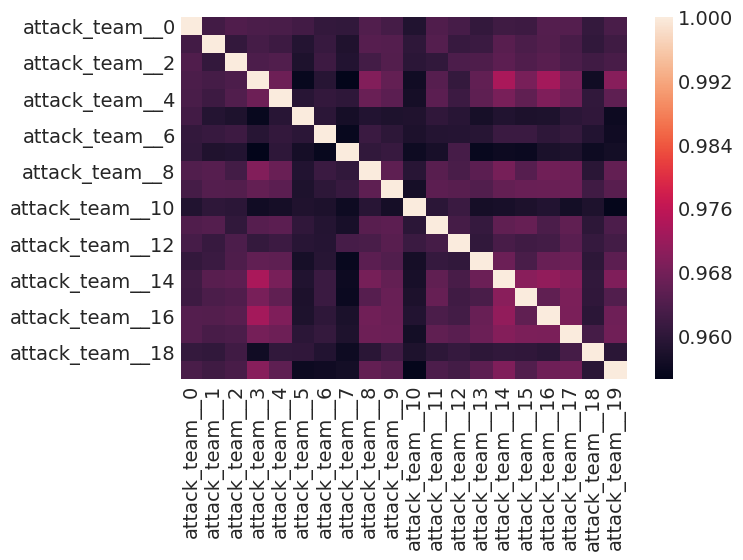

In [33]:
sns.heatmap(pm.trace_to_dataframe(trace_1_nc, varnames=['attack_team']).corr())

* Too much variance in parameter estimates.
* Model is unidentifiable. Adding any constant k to all the attack and defense parameters will lead to the same predictions
* Estimates are strongly correlated.
* Need to add some more constraints.

## Model 2

* No home team advantage.
* Add sum to one constraint on the attack and defense parameters of the teams.
* Non-centered parametrization

attack_group_mean ~ Normal(0, 1)  
attack_group_sd ~ HalfCauchy(1)  
attack_team<sub>i</sub> ~ Normal(attack_group_mean, attack_group_sd)  

defense_group_mean ~ Normal(0, 1)  
defense_group_sd ~ HalfCauchy(1)  
defense_team<sub>i</sub> ~ Normal(defense_group_mean, defense_group_sd)  

log(home_rate<sub>i, j</sub>) = attack_team<sub>i</sub> - defense_team<sub>j</sub>  
home_goals<sub>i, j</sub> ~ Poisson(home_rate<sub>i, j</sub>)<br>
log(away_rate<sub>i, j</sub>) = attack_team<sub>j</sub> - defense_team<sub>i</sub>  
away_goals<sub>i, j</sub> ~ Poisson(away_rate<sub>i, j</sub>)  

$\sum_{i=1}^{20} attackteam_i$ = 0  
$\sum_{i=1}^{20} defenseteam_i$ = 0

In [13]:
import theano.tensor as tt

In [14]:
with pm.Model() as model_2:
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=1)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team_z = pm.Normal('attack_team_z', mu=0, sd=1, shape=n_teams)
    attack_team_ = attack_group_mean + attack_group_sd * attack_team_z
    #attack_team = pm.Deterministic('attack_team', tt.concatenate([attack_team_, tt.stack(-tt.sum(attack_team_))]))
    attack_team = pm.Deterministic('attack_team', attack_team_ - tt.mean(attack_team_))
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=1)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team_z = pm.Normal('defense_team_z', mu=0, sd=1, shape=n_teams)
    defense_team_ = defense_group_mean + defense_group_sd * defense_team_z
    #defense_team = pm.Deterministic('defense_team', tt.concatenate([defense_team_, tt.stack(-tt.sum(defense_team_))]))
    defense_team = pm.Deterministic('defense_team', defense_team_ - tt.mean(defense_team_))
    
    home_rate = pm.math.exp(attack_team[df.HomeTeamId] - defense_team[df.AwayTeamId])
    away_rate = pm.math.exp(attack_team[df.AwayTeamId] - defense_team[df.HomeTeamId])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    trace_2 = pm.sample(1000, tune=1000)

/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defense_team_z, defense_group_sd, defense_group_mean, attack

/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matp

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a119185d0>,
      dtype=object)

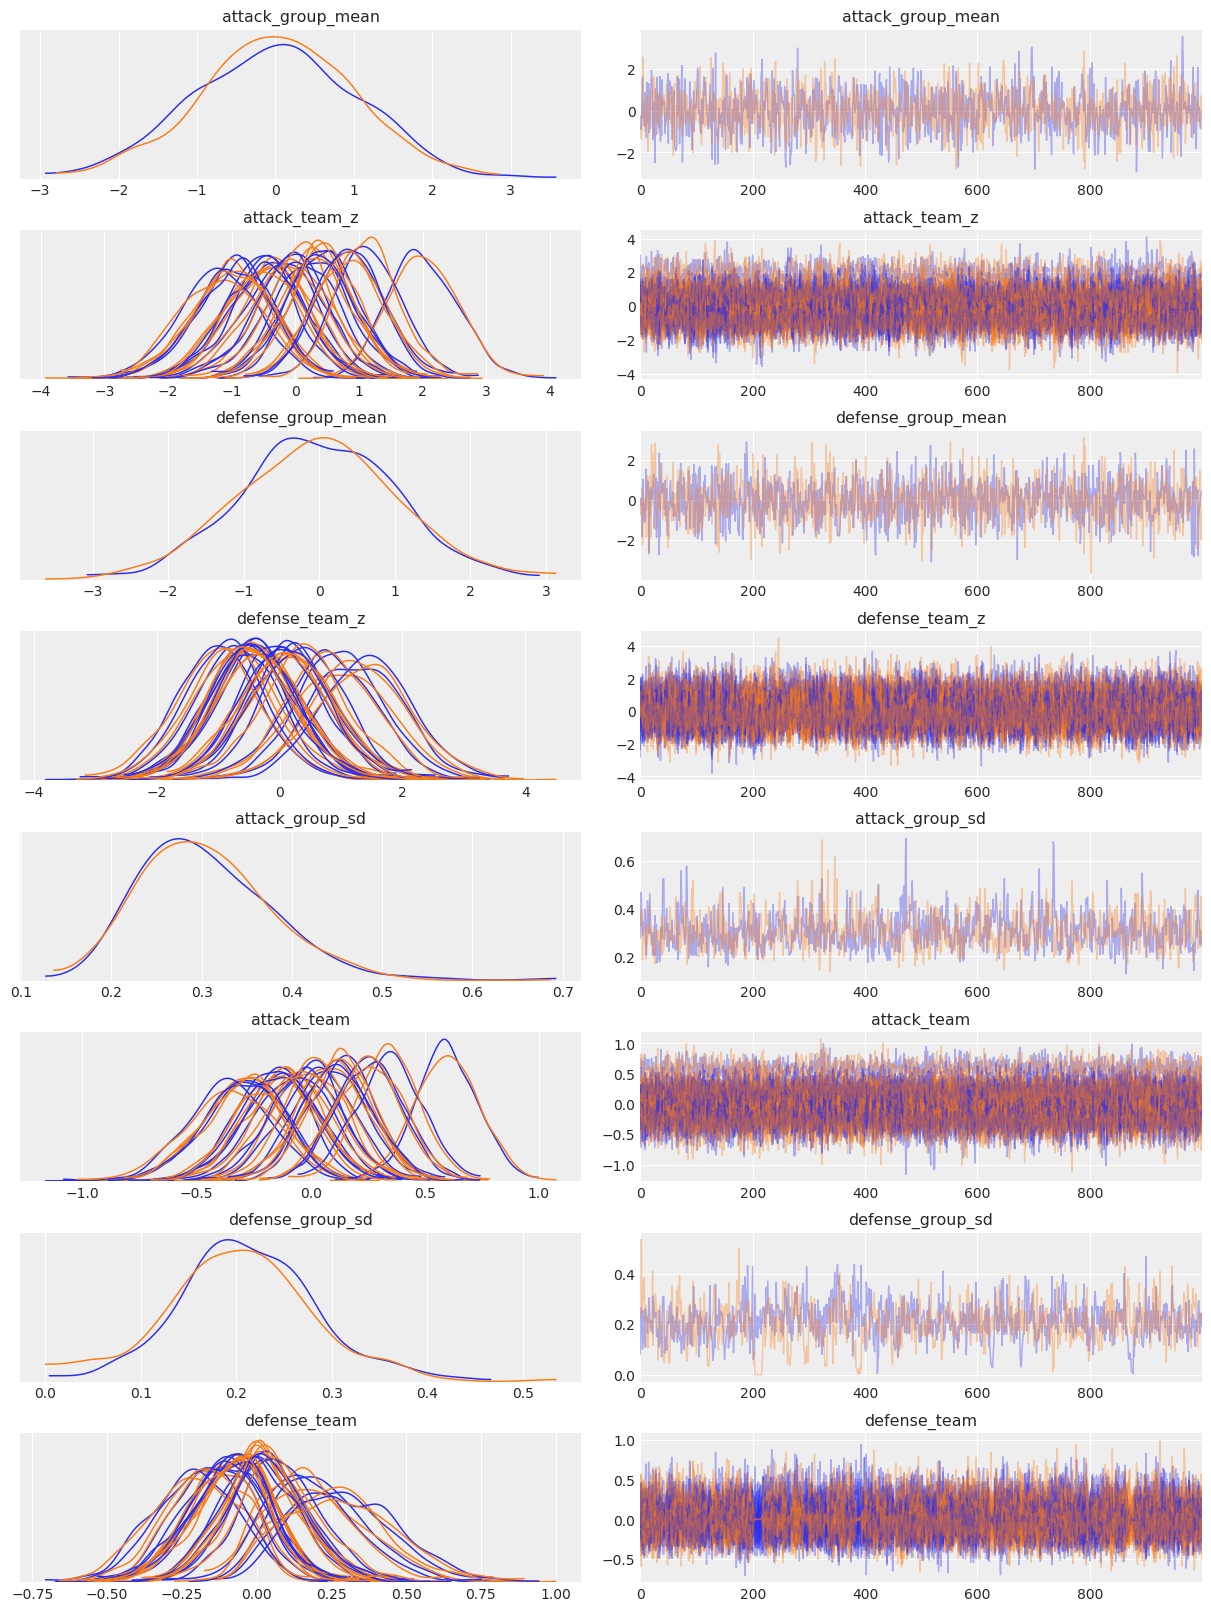

In [15]:
az.plot_trace(trace_2, compact=True)

In [16]:
az.summary(trace_2, var_names=['attack_group_mean', 'attack_group_sd', 'attack_team'],
           credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
attack_group_mean,0.015,1.014,-1.569,1.668,0.023,0.022,1895.0,1083.0,1896.0,1533.0,1.00
attack_group_sd,0.305,0.074,0.182,0.404,0.003,0.002,814.0,814.0,813.0,1226.0,1.00
attack_team[0],-0.124,0.166,-0.379,0.135,0.003,0.003,2275.0,1472.0,2291.0,1624.0,1.00
attack_team[1],-0.132,0.165,-0.396,0.122,0.003,0.004,2472.0,1077.0,2455.0,1183.0,1.00
attack_team[2],-0.079,0.165,-0.340,0.175,0.003,0.003,2850.0,1361.0,2844.0,1344.0,1.00
attack_team[3],0.597,0.139,0.382,0.822,0.003,0.002,2482.0,2364.0,2465.0,1279.0,1.00
attack_team[4],0.112,0.154,-0.123,0.364,0.003,0.003,2495.0,1642.0,2501.0,1604.0,1.00
attack_team[5],-0.303,0.176,-0.569,-0.021,0.004,0.003,2350.0,2025.0,2341.0,1506.0,1.00
attack_team[6],-0.172,0.163,-0.427,0.082,0.003,0.003,2725.0,1647.0,2738.0,1607.0,1.00
attack_team[7],-0.284,0.180,-0.589,-0.017,0.004,0.003,1665.0,1553.0,1667.0,1377.0,1.00


In [17]:
az.summary(trace_2, var_names=['defense_group_mean', 'defense_group_sd', 'defense_team'],
           credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
defense_group_mean,-0.022,1.030,-1.774,1.500,0.024,0.021,1835.0,1186.0,1838.0,1677.0,1.00
defense_group_sd,0.207,0.076,0.077,0.326,0.004,0.003,457.0,457.0,468.0,324.0,1.01
defense_team[0],-0.067,0.133,-0.280,0.143,0.003,0.003,2306.0,1370.0,2266.0,1490.0,1.00
defense_team[1],0.207,0.160,-0.037,0.461,0.004,0.003,1418.0,1418.0,1347.0,1310.0,1.00
defense_team[2],0.263,0.170,-0.010,0.510,0.005,0.003,1243.0,1243.0,1155.0,550.0,1.00
defense_team[3],0.046,0.135,-0.169,0.264,0.003,0.003,2235.0,1069.0,2232.0,1562.0,1.00
defense_team[4],-0.144,0.133,-0.366,0.042,0.003,0.002,2197.0,2073.0,2169.0,1534.0,1.00
defense_team[5],0.003,0.127,-0.202,0.203,0.003,0.003,1987.0,1136.0,2015.0,1627.0,1.00
defense_team[6],-0.112,0.131,-0.321,0.090,0.003,0.002,1908.0,1676.0,1922.0,1687.0,1.00
defense_team[7],-0.211,0.145,-0.443,0.009,0.004,0.003,1266.0,1266.0,1235.0,1503.0,1.00


Text(0, 0.5, 'Density')

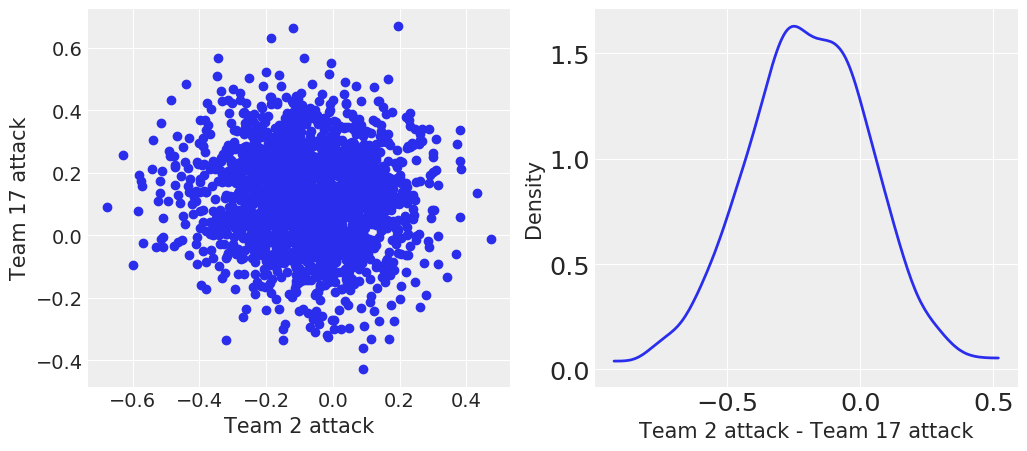

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(trace_2['attack_team'][:, 2], trace_2['attack_team'][:, 17], 'o')
axs[0].set_xlabel('Team 2 attack')
axs[0].set_ylabel('Team 17 attack')

az.plot_dist(trace_2['attack_team'][:, 2] - trace_2['attack_team'][:, 17], ax=axs[1])
axs[1].set_xlabel('Team 2 attack - Team 17 attack')
axs[1].set_ylabel('Density')

In [23]:
pm.trace_to_dataframe(trace_2, varnames=['attack_team']).corr()

,attack_team__0,attack_team__1,attack_team__2,attack_team__3,attack_team__4,attack_team__5,attack_team__6,attack_team__7,attack_team__8,attack_team__9,attack_team__10,attack_team__11,attack_team__12,attack_team__13,attack_team__14,attack_team__15,attack_team__16,attack_team__17,attack_team__18,attack_team__19
attack_team__0,1.000000,-0.090500,-0.096407,-0.062731,-0.040145,0.051531,-0.018416,-0.058192,-0.013096,-0.059643,-0.078365,-0.046391,-0.059003,-0.028701,-0.109274,-0.017747,-0.111671,-0.006141,-0.084775,-0.119615
attack_team__1,-0.090500,1.000000,-0.097229,-0.102612,-0.066629,-0.044727,-0.059868,-0.001976,-0.048799,-0.023298,-0.011007,-0.032747,-0.037256,-0.105399,-0.038382,-0.016737,-0.055510,-0.065869,-0.046274,-0.107896
attack_team__2,-0.096407,-0.097229,1.000000,-0.037490,-0.033725,-0.072847,-0.120787,-0.073357,0.007591,-0.006218,-0.028119,-0.063354,-0.042877,-0.057481,-0.101757,-0.074922,0.030635,-0.075760,-0.034128,-0.052275
attack_team__3,-0.062731,-0.102612,-0.037490,1.000000,0.032358,-0.171161,-0.093486,-0.119309,-0.011395,-0.076020,-0.160503,0.031251,-0.095885,-0.001069,0.069039,0.045063,0.065259,0.039692,-0.163303,0.055906
attack_team__4,-0.040145,-0.066629,-0.033725,0.032358,1.000000,-0.103782,-0.057522,-0.128914,-0.074673,-0.054776,-0.060974,-0.009405,-0.030672,-0.053343,-0.028187,-0.014947,-0.034807,-0.042408,-0.086541,-0.031592
attack_team__5,0.051531,-0.044727,-0.072847,-0.171161,-0.103782,1.000000,-0.037616,0.060021,-0.100420,-0.120345,0.025086,-0.100776,-0.071822,-0.021099,-0.115684,-0.093486,-0.151332,-0.034764,-0.022477,-0.048374
attack_team__6,-0.018416,-0.059868,-0.120787,-0.093486,-0.057522,-0.037616,1.000000,-0.061417,-0.068443,-0.004163,-0.010274,-0.069497,-0.025973,-0.028423,-0.089077,-0.022766,-0.120137,-0.071006,0.012295,-0.104087
attack_team__7,-0.058192,-0.001976,-0.073357,-0.119309,-0.128914,0.060021,-0.061417,1.000000,-0.026056,-0.071131,-0.013892,-0.054646,-0.075952,-0.107867,-0.089713,-0.064463,-0.123320,-0.044978,-0.027214,-0.093884
attack_team__8,-0.013096,-0.048799,0.007591,-0.011395,-0.074673,-0.100420,-0.068443,-0.026056,1.000000,-0.075308,-0.090655,-0.026672,-0.067820,-0.049461,-0.042490,-0.114533,-0.018000,-0.059301,-0.043255,-0.034450
attack_team__9,-0.059643,-0.023298,-0.006218,-0.076020,-0.054776,-0.120345,-0.004163,-0.071131,-0.075308,1.000000,-0.063087,-0.094438,-0.072293,-0.029819,0.011356,-0.010549,-0.016460,0.003453,-0.068317,-0.126551


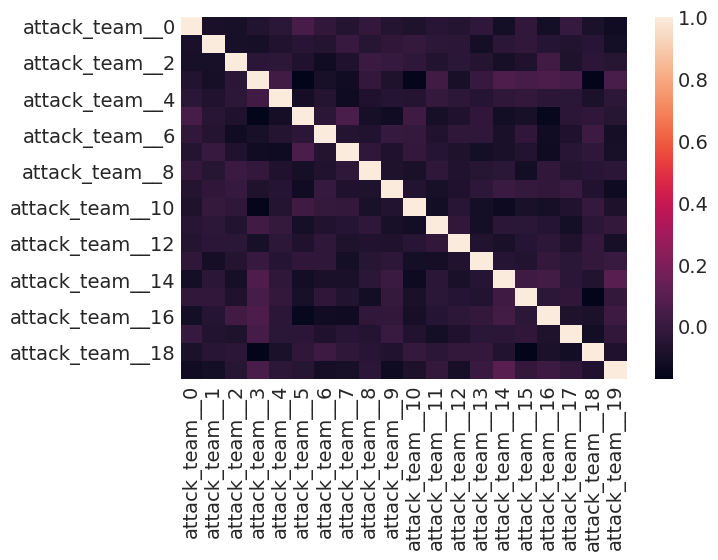

In [26]:
sns.heatmap(pm.trace_to_dataframe(trace_2, varnames=['attack_team']).corr())

* The strong correlation between estimates for each team is gone.
* The model is identifiable.
* The distribution of difference between the 2 teams seems to be similar for model 1 with non-centered parametrization and model 2 but the correlation between the 2 teams' estimates is removed.
* Note that the color bar is different for model 1 and model 2 correlation heatmaps.